# Read and explore the dataset. EDA

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from   sklearn.model_selection import train_test_split as train_test
import time
import seaborn as sns
import pylab as pl
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
    
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("ratings_Electronics.csv",
                  names=["userId", "productId", "ratings", "timestamp"])

In [3]:
data.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
# droping timestamp column as we don't need it for our recommended system
ratings_Electronics = data.drop('timestamp', axis=1)
ratings_Electronics.head()

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [5]:
print ('Number of entries in dataset : ', ratings_Electronics.shape[0])
print ('Number of features in dataset : ', ratings_Electronics.shape[1])

Number of entries in dataset :  7824482
Number of features in dataset :  3


In [6]:
print ("Checking type of data, missing data")
ratings_Electronics.info()

Checking type of data, missing data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId       object
productId    object
ratings      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [7]:
# getting unique users
unique_users = ratings_Electronics['userId'].unique()
print ('length of unique users : ', len(unique_users))

length of unique users :  4201696


In [8]:
# getting unique products
# unique_prducts = ratings_Electronics['productId'].unique()
# print ('length of unique products: ', len(unique_prducts)

In [9]:
# Plotting user counts

In [10]:
user_count_data = pd.DataFrame(ratings_Electronics.groupby('userId')['userId'].count())  

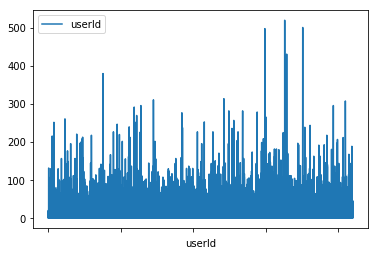

In [11]:
user_count_data.plot()

In [12]:
# Plotting product counts

In [13]:
product_count_data = pd.DataFrame(ratings_Electronics.groupby('productId')['productId'].count())  

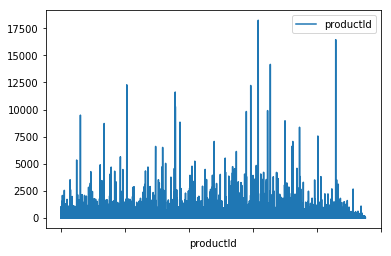

In [14]:
product_count_data.plot()

# Considering subset of dataset to make it less sparse/more dense. (For example, users only who has given 50 or more number of ratings )

### filtering rating electronics  Data frame, with such users where number of users are 50 or more

In [15]:
rating_subset = ratings_Electronics[ratings_Electronics.groupby('userId')['userId'].transform('size') > 49]

### plotting a countplot for users from rating subset Data Frame

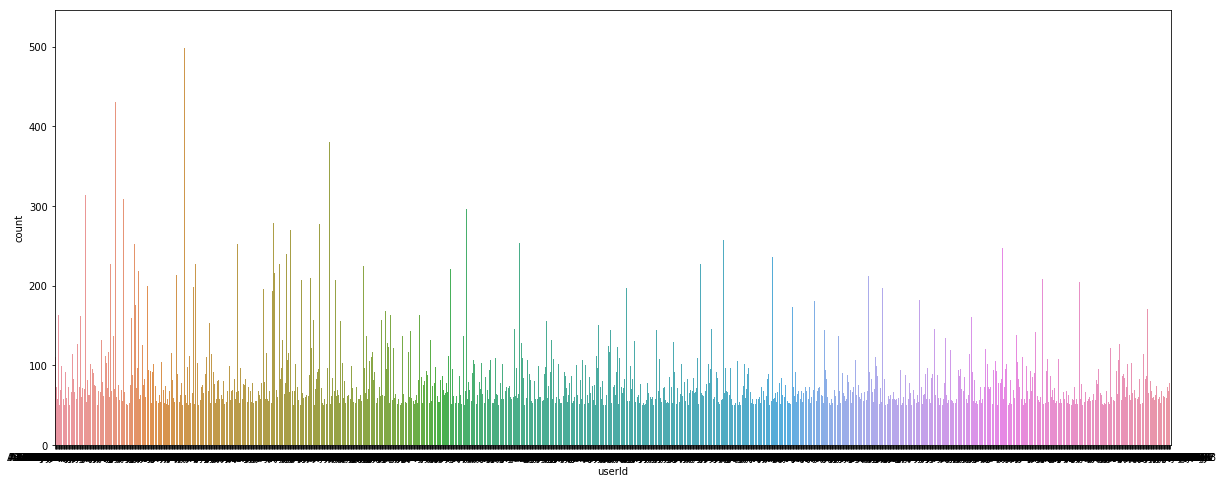

In [16]:
plt.figure(figsize=(20,8))
sns.countplot(data=rating_subset, x='userId')

In [17]:
print ('Number of entries in rating subset : ', rating_subset.shape[0])

Number of entries in rating subset :  125871


### getting value counts of each user

In [18]:
count_data = rating_subset.userId.value_counts()
count_data.head()

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: userId, dtype: int64

### getting all the unique users from rating_subset

In [19]:
unique_users_subset = rating_subset['userId'].unique()
print (unique_users_subset)
print ('Size of unique users subset ',len(unique_users_subset))

['A3BY5KCNQZXV5U' 'AT09WGFUM934H' 'A32HSNCNPRUMTR' ... 'AT53ZTTO707MB'
 'A1X3ESYZ79H59E' 'A328S9RN3U5M68']
Size of unique users subset  1540


### getting all the unique users from rating_subset

In [20]:
unique_prducts_subset = rating_subset['productId'].unique()
print (unique_users_subset)
print ('Size of unique users subset ',len(unique_users_subset))

['A3BY5KCNQZXV5U' 'AT09WGFUM934H' 'A32HSNCNPRUMTR' ... 'AT53ZTTO707MB'
 'A1X3ESYZ79H59E' 'A328S9RN3U5M68']
Size of unique users subset  1540


### Grouping products by product Id and aggregating ratings based on count

In [21]:
product_grouped = rating_subset.groupby(['productId']).agg({'ratings':'count'}).reset_index()

In [22]:
product_grouped.head()

,productId,ratings
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,4
4,1400501466,6


In [23]:
# sum of all ratings
grouped_sum = product_grouped['ratings'].sum()
print ('Sum of all ratings: ', grouped_sum)

Sum of all ratings:  125871


### creating a  column 'percentage' to check % of ratings for each products

In [24]:
product_grouped['percentage'] = product_grouped['ratings'].div(grouped_sum) * 100

In [25]:
product_grouped.head()

,productId,ratings,percentage
0,0594451647,1,0.000794
1,0594481813,1,0.000794
2,0970407998,2,0.001589
3,0972683275,4,0.003178
4,1400501466,6,0.004767


In [26]:
# sorting the grouped products based on ratings and product id
product_grouped_sorted = product_grouped.sort_values(['ratings', 'productId'], ascending=[0,1])

In [27]:
product_grouped_sorted.head()

,productId,ratings,percentage
39003,B0088CJT4U,206,0.163660
24827,B003ES5ZUU,184,0.146181
11078,B000N99BBC,167,0.132676
38250,B007WTAJTO,164,0.130292
38615,B00829TIEK,149,0.118375


# Split the data randomly into train and test dataset.

### spliting data set to train, test for popularity recommendation system

In [28]:
train_data, test_data = train_test(rating_subset, test_size=.30, random_state=167)

### spliting data set to train, test for collabarative recommendation system using surprise package

In [29]:
# importing Dataset and Reader from surprise package
from surprise import Dataset, Reader

In [30]:
# loading the data set using surprise package
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_subset, reader)

In [31]:
#spliting training and tesing dataset
trainset, testset = train_test_split(data, test_size=.30, random_state=167)

# 4. Build Popularity Recommender model.

### creating popularity based recommender model below

In [32]:
#Class for Popularity based Recommender System model
class popularity_based_recommender():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.product_id = None
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def create(self, train_data, user_id, product_id, num_of_recos):
        self.train_data = train_data
        self.user_id = user_id
        self.product_id = product_id

        #Get a count of user_ids for each unique product as recommendation score
        train_data_grouped = train_data.groupby([self.product_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
    
        #Sort the product based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.product_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(num_of_recos)

    #Use the popularity based recommender system model to
    #make recommendations
    def recommend(self, user_id):
        user_recommendations = self.popularity_recommendations
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['userId'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]        
        return user_recommendations

In [33]:
popularity_model = popularity_based_recommender()

# Build Collaborative Filtering model

In [34]:
# user item rating data can be obtained as follows
user_records = trainset.ur
type(user_records)

collections.defaultdict

In [35]:
# checking user record of first index from surprise package trainset user data
user_records[0]

[(0, 4.0),
 (16, 5.0),
 (1131, 5.0),
 (1347, 5.0),
 (2137, 5.0),
 (3166, 5.0),
 (3221, 5.0),
 (4399, 2.0),
 (4681, 5.0),
 (4762, 5.0),
 (5047, 4.0),
 (5335, 5.0),
 (5726, 5.0),
 (1345, 5.0),
 (1988, 4.0),
 (8469, 5.0),
 (8526, 2.0),
 (8575, 5.0),
 (559, 5.0),
 (8679, 5.0),
 (8787, 5.0),
 (9341, 5.0),
 (9735, 5.0),
 (10488, 5.0),
 (10642, 5.0),
 (11176, 5.0),
 (11360, 5.0),
 (11512, 5.0),
 (12097, 5.0),
 (6774, 5.0),
 (330, 5.0),
 (287, 5.0),
 (6361, 5.0),
 (6662, 3.0),
 (13926, 5.0),
 (2169, 5.0),
 (14291, 3.0),
 (14737, 5.0),
 (15151, 5.0),
 (6671, 5.0),
 (3602, 4.0),
 (16492, 5.0),
 (16537, 5.0),
 (17229, 5.0),
 (17422, 5.0),
 (17789, 5.0),
 (7352, 5.0),
 (18170, 2.0),
 (3193, 5.0),
 (11516, 5.0),
 (19905, 3.0),
 (16946, 5.0),
 (561, 3.0),
 (13617, 5.0),
 (21420, 5.0),
 (13009, 5.0),
 (10267, 5.0),
 (2545, 5.0),
 (22160, 5.0),
 (23176, 5.0),
 (23252, 5.0),
 (2397, 5.0),
 (16865, 5.0),
 (18628, 5.0),
 (6172, 5.0),
 (24523, 5.0),
 (25465, 5.0),
 (4216, 5.0),
 (25757, 5.0),
 (25849, 5.0

In [36]:
# However the ids are the inner ids and not the raw ids
# raw ids can be obatined as follows

print(trainset.to_raw_uid(0))
print(trainset.to_raw_iid(1066))

A3REK3OFONWB1Q
B000INZRZW


In [37]:
from surprise import KNNWithMeans
from surprise import accuracy

### creating collaborative filtering model using KNNWithMeans from surprise package. Here I am creting user-user similarity model as we want to recommend products based on user habits

In [38]:
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson', 'user_based': True})

In [39]:
# fitting the training set on the above declared model
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [40]:
# we can now query for specific predicions
uid = str(196)  # raw user id
iid = str(302)  # raw item id

In [41]:
# get a prediction for specific users and items.
pred = algo.predict(uid, iid, verbose=True)

user: 196        item: 302        r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}


# Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

### Evaluating Popularity based model

In [42]:
popularity_model.create(train_data, 'userId', 'productId', 10)

In [43]:
# getting user id at index 20
user_id = unique_users_subset[20]
# recmmending products for the above declared user
popularity_model.recommend(user_id)

,userId,productId,score,Rank
30941,A341HCMGNZCBIT,B0088CJT4U,148,1.0
19646,A341HCMGNZCBIT,B003ES5ZUU,124,2.0
30384,A341HCMGNZCBIT,B007WTAJTO,111,3.0
8722,A341HCMGNZCBIT,B000N99BBC,110,4.0
31215,A341HCMGNZCBIT,B008DWCRQW,102,5.0
30646,A341HCMGNZCBIT,B00829THK0,101,6.0
30650,A341HCMGNZCBIT,B00829TIEK,99,7.0
17398,A341HCMGNZCBIT,B002R5AM7C,95,8.0
22834,A341HCMGNZCBIT,B004CLYEDC,85,9.0
24609,A341HCMGNZCBIT,B004T9RR6I,81,10.0


#### not sure how to calculate RMSE for popularity based recommender model. we didn't get any infrmation abut it in our residency as well. Please clarify on calculating RMSE for popularity based recommender model

### Evaluating Collaborative Filtering Model using RMSE

In [44]:
print ('length of test set: ',len(testset))

length of test set:  37762


In [45]:
testset[0:5]

[('A1GWG5CWLKJ7ET', 'B005INACOS', 4.0),
 ('A5Q1FK0FWU7DH', 'B002C744K6', 5.0),
 ('A3SOJO7Z7R9WIA', 'B004JOQSEA', 5.0),
 ('A2OWR5G2OAQF7C', 'B006ZBWV0K', 4.0),
 ('AQR4HPVSOPS08', 'B0013V3CC8', 4.0)]

In [46]:
# Get recommendation predictions for test data
test_pred = algo.test(testset)
test_pred

[Prediction(uid='A1GWG5CWLKJ7ET', iid='B005INACOS', r_ui=4.0, est=4.406779661016949, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A5Q1FK0FWU7DH', iid='B002C744K6', r_ui=5.0, est=4.16, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3SOJO7Z7R9WIA', iid='B004JOQSEA', r_ui=5.0, est=3.411764705882353, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2OWR5G2OAQF7C', iid='B006ZBWV0K', r_ui=4.0, est=4.5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AQR4HPVSOPS08', iid='B0013V3CC8', r_ui=4.0, est=4.63265306122449, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A6VXZ1EEPRTLV', iid='B00CIZ2238', r_ui=4.0, est=4.850180122907395, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A3V6QSTG2T9MIO', iid='B005RXGZOU', r_ui=3.0, est=3.987675801072931, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A16WP8NTPYB0ZM', iid='B0031GNYCQ', r_ui=2.0, est=4.26443382628

In [47]:
print('RMSE of predicted test data: ', accuracy.rmse(test_pred))

RMSE: 1.0537
RMSE of predicted test data:  1.0537438346916688


In [48]:
# View a particular prediction
print ('Prediction data for 10th index data \n', test_pred[10])

Prediction data for 10th index data 
 user: A3N4VTNFPMTHEF item: B0021Y73W6 r_ui = 4.00   est = 2.29   {'actual_k': 1, 'was_impossible': False}


In [49]:
# convert test predictions results to dataframe
test_pred_df = pd.DataFrame(test_pred)
test_pred_df["was_impossible"] = [x["was_impossible"] for x in test_pred_df["details"]]

In [50]:
# predicting data for a particular user and product id
algo.predict(uid='A3SOJO7Z7R9WIA', iid='B004JOQSEA')

Prediction(uid='A3SOJO7Z7R9WIA', iid='B004JOQSEA', r_ui=None, est=3.411764705882353, details={'actual_k': 0, 'was_impossible': False})

In [51]:
# getting data where was_impossible is false
test_pred_df.loc[test_pred_df.was_impossible==True].head(5)

,uid,iid,r_ui,est,details,was_impossible
7,A16WP8NTPYB0ZM,B0031GNYCQ,2.0,4.264434,"{'was_impossible': True, 'reason': 'User and/o...",True
8,AT53ZTTO707MB,B00BWHILC4,5.0,4.264434,"{'was_impossible': True, 'reason': 'User and/o...",True
9,A16CVJUQOB6GIB,B001KN2ANG,5.0,4.264434,"{'was_impossible': True, 'reason': 'User and/o...",True
12,A20H1M28WLI9J2,B007CL4IEY,1.0,4.264434,"{'was_impossible': True, 'reason': 'User and/o...",True
19,A1J75JJ0Q2OEJN,B0014CT6Q2,2.0,4.264434,"{'was_impossible': True, 'reason': 'User and/o...",True


# Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products.

In [52]:
# number of recommendations
k = 5

### Getting top 5 Recommendations using Popularity based recommendations system

In [53]:
popularity_model.create(train_data, 'userId', 'productId', k)

In [54]:
# getting user id at index 20
user_id = unique_users_subset[20]

In [55]:
# recmmending products for the above declared user
popularity_model.recommend(user_id)

,userId,productId,score,Rank
30941,A341HCMGNZCBIT,B0088CJT4U,148,1.0
19646,A341HCMGNZCBIT,B003ES5ZUU,124,2.0
30384,A341HCMGNZCBIT,B007WTAJTO,111,3.0
8722,A341HCMGNZCBIT,B000N99BBC,110,4.0
31215,A341HCMGNZCBIT,B008DWCRQW,102,5.0


### Getting top 5 Recommendations using Collaborative Filtering model recommendations system

In [56]:
predictions = algo.test(testset)

In [57]:
predictions_df = pd.DataFrame([[x.uid,x.iid, x.est] for x in predictions])

In [58]:
predictions_df.columns = ["userId","productId","est_rating"]
predictions_df_sorted = predictions_df.sort_values(by = ["userId", "est_rating"],ascending=False)

In [59]:
# get top 5 recommendations for user 'A100WO06OQR8BQ'
predictions_df_sorted.loc[predictions_df_sorted['userId'] == 'A100WO06OQR8BQ'].head(5)

,userId,productId,est_rating
15893,A100WO06OQR8BQ,B001NLV4TQ,4.415349
5585,A100WO06OQR8BQ,B0002L5R78,4.385587
22572,A100WO06OQR8BQ,B00DR0C96S,4.377409
71,A100WO06OQR8BQ,B00004TDRH,4.264434
3180,A100WO06OQR8BQ,B00186URQC,4.264434


# Observations

### We are recommending most bought products in a popularity based recommended system for any new user, which also has a problem i.e. it is not a customized recommendation the particular user

### The user based collaborative fitering recommender system identifies users that are similar to the queried user and estimate the desired rating to be the weighted average of the ratings of these similar users. i.e. we need to find the neighbours of th e user

### as we see lot of predictions are impossible, means we dont have proper information for some the items/user i.e. there is high sparsity of information

### I am uing clustering based algorithm KNN to find out the similarity between users